# Ranking the outcome of the PSoup

### 1. Add the comparison coloumn

In [2]:
import pandas as pd

# Load your CSV file
df = pd.read_csv(r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Weighting_Loss Function\Results_Wheight_PS.csv') 

# Define function to compute 'Compare with'
def determine_compare_with(treatment):
    if "WT" in treatment and "+" in treatment:
        return "WT, +" + treatment.split("+")[1].split("_")[0].strip()  # Extract gene name after '+'
    elif "WT" in treatment:
        return "Skip"
    elif "+" in treatment:
        return treatment.split(",")[0].strip()
    else:
        return "WT"

# Apply the logic
df['Compare with'] = df['Psoup treatment'].apply(determine_compare_with)

# Save the updated file
df.to_csv(r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Weighting_Loss Function\Results_Wheight_PS_Compared.csv', index=False)
print("Saved updated file as 'Results_Wheight_PS_Compared.csv'")


Saved updated file as 'Results_Wheight_PS_Compared.csv'


### 2. Rank the PSoup outcome and also add with what the treatment will be compared. 

In [3]:
import pandas as pd

# Specify the input CSV file path
input_file = r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Weighting_Loss Function\Results_Wheight_PS_Compared.csv'  # Replace with the actual path to your input CSV file

# Specify the output CSV file path
output_file = r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Weighting_Loss Function\Sorted_PSoup.csv'  # Replace with the desired path for the sorted output CSV file

try:
    # Read the input CSV file
    df = pd.read_csv(input_file)

    # Sort the DataFrame by 'Hormones.Sustained_growth' column in ascending order
    sorted_df = df.sort_values(by="Hormones.Sustained_growth", ascending=True).reset_index(drop=True)

    # Add a ranking column
    ranks = []
    current_rank = 1
    reference_value = sorted_df["Hormones.Sustained_growth"].iloc[0]  # Start with the first value as reference

    for value in sorted_df["Hormones.Sustained_growth"]:
        if abs(value - reference_value) > 0.05:  # Compare against the reference value
            current_rank += 1  # Increment rank when the difference exceeds 0.05
            reference_value = value  # Update the reference value for the next comparison
        ranks.append(current_rank)

    sorted_df["Rank"] = ranks

    # Save the sorted and ranked DataFrame to the output CSV file
    sorted_df.to_csv(output_file, index=False)

    print(f"Sorted and ranked CSV file saved successfully as: {output_file}")
except FileNotFoundError:
    print(f"Error: File not found at path '{input_file}'. Please check the file path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")


Sorted and ranked CSV file saved successfully as: C:\Users\uqcmitsa\OneDrive - The University of Queensland\Weighting_Loss Function\Sorted_PSoup.csv


### 3. Sort the results

In [46]:
import pandas as pd
from scipy.stats import kendalltau

def rank_psoup_treatments(data_file, rank_file, output_file):
    try:
        # Load the main data and the ranking data with a specified encoding
        data = pd.read_csv(data_file, encoding='latin1')  # Change encoding if needed
        ranks = pd.read_csv(rank_file, encoding='latin1')  # Change encoding if needed

        # Create a dictionary for fast lookup of ranks
        rank_dict = dict(zip(ranks['Psoup treatment'], ranks['Rank']))

        # Define a function to assign ranks based on the dictionary
        def get_rank(treatment):
            return rank_dict.get(treatment, float('inf'))  # Default rank to infinity if not found

        # Apply the ranking function to the 'Psoup Treatment' column
        data['Psoup Rank'] = data['Psoup Treatment'].apply(get_rank)

        # Sort by Paper, Experiment, and Psoup Rank
        data = data.sort_values(by=['Paper', 'Experiment', 'Psoup Rank'])

        # Assign a sequential ranking within each Paper and Experiment
        data['Psoup Ranking'] = data.groupby(['Paper', 'Experiment'])['Psoup Rank'].rank(method='dense').astype(int)

        # Calculate Kendall Tau distance and normalized distance
        results = []
        all_normalized_distances = []  # Collect all normalized distances for percentage calculation

        for (paper, experiment), group in data.groupby(['Paper', 'Experiment']):
            significant_ranking = group['Significant ranking'].tolist()
            psoup_ranking = group['Psoup Ranking'].tolist()

            # Calculate Kendall Tau distance and normalized distance
            kendall_tau, _ = kendalltau(significant_ranking, psoup_ranking)
            normalized_distance = (1 - kendall_tau) / 2
            all_normalized_distances.append(normalized_distance)

            # Add Kendall Tau and normalized distance to each row in the group
            group['Kendall Tau'] = kendall_tau
            group['Normalized Kendall Distance'] = normalized_distance

            # Append group with updated columns
            results.append(group)

        # Concatenate all groups into a single DataFrame
        final_df = pd.concat(results)

        # Calculate percentage distribution for normalized Kendall distances
        total_experiments = len(all_normalized_distances)
        percent_0_0_3 = sum(0 <= d < 0.3 for d in all_normalized_distances) / total_experiments * 100
        percent_0_3_0_5 = sum(0.3 <= d < 0.5 for d in all_normalized_distances) / total_experiments * 100
        percent_0_5_0_7 = sum(0.5 <= d < 0.7 for d in all_normalized_distances) / total_experiments * 100
        percent_0_7_1 = sum(0.7 <= d <= 1 for d in all_normalized_distances) / total_experiments * 100

        # Add the percentage columns to the DataFrame (same value for all rows)
        final_df['Percentage_0_0.3'] = percent_0_0_3
        final_df['Percentage_0.3_0.5'] = percent_0_3_0_5
        final_df['Percentage_0.5_0.7'] = percent_0_5_0_7
        final_df['Percentage_0.7_1'] = percent_0_7_1

        # Save the updated data with all columns
        final_df.to_csv(output_file, index=False, encoding='utf-8')
        print(f"Processed data with Kendall Tau saved to {output_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
# Replace 'data_file.csv' and 'rank_file.csv' with your file paths
rank_psoup_treatments(
    data_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Bio_Data_order_B_M_Twiked.csv', 
    rank_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Sorted_PSoup.csv', 
    output_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Kendall_Tau_Results.csv'
)


Processed data with Kendall Tau saved to C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Kendall_Tau_Results.csv


### 3b. Sort the results of different weights

In [ ]:
import pandas as pd
from scipy.stats import kendalltau

def rank_psoup_treatments(data_file, rank_file, output_file):
    try:
        # Load the main data and the ranking data with a specified encoding
        data = pd.read_csv(data_file, encoding='latin1')  # Change encoding if needed
        ranks = pd.read_csv(rank_file, encoding='latin1')  # Change encoding if needed

        # Create a dictionary for fast lookup of ranks
        rank_dict = dict(zip(ranks['Psoup treatment'], ranks['Rank']))

        # Define a function to assign ranks based on the dictionary
        def get_rank(treatment):
            return rank_dict.get(treatment, float('inf'))  # Default rank to infinity if not found

        # Apply the ranking function to the 'Psoup Treatment' column
        data['Psoup Rank'] = data['Psoup Treatment'].apply(get_rank)

        # Sort by Paper, Experiment, and Psoup Rank
        data = data.sort_values(by=['Paper', 'Experiment', 'Psoup Rank'])

        # Assign a sequential ranking within each Paper and Experiment
        data['Psoup Ranking'] = data.groupby(['Paper', 'Experiment'])['Psoup Rank'].rank(method='dense').astype(int)

        # Calculate Kendall Tau distance and normalized distance
        results = []
        all_normalized_distances = []  # Collect all normalized distances for percentage calculation

        for (paper, experiment), group in data.groupby(['Paper', 'Experiment']):
            significant_ranking = group['Significant ranking'].tolist()
            psoup_ranking = group['Psoup Ranking'].tolist()

            # Calculate Kendall Tau distance and normalized distance
            kendall_tau, _ = kendalltau(significant_ranking, psoup_ranking)
            normalized_distance = (1 - kendall_tau) / 2
            all_normalized_distances.append(normalized_distance)

            # Add Kendall Tau and normalized distance to each row in the group
            group['Kendall Tau'] = kendall_tau
            group['Normalized Kendall Distance'] = normalized_distance

            # Append group with updated columns
            results.append(group)

        # Concatenate all groups into a single DataFrame
        final_df = pd.concat(results)

        # Calculate percentage distribution for normalized Kendall distances
        total_experiments = len(all_normalized_distances)
        percent_0_0_3 = sum(0 <= d < 0.3 for d in all_normalized_distances) / total_experiments * 100
        percent_0_3_0_5 = sum(0.3 <= d < 0.5 for d in all_normalized_distances) / total_experiments * 100
        percent_0_5_0_7 = sum(0.5 <= d < 0.7 for d in all_normalized_distances) / total_experiments * 100
        percent_0_7_1 = sum(0.7 <= d <= 1 for d in all_normalized_distances) / total_experiments * 100

        # Add the percentage columns to the DataFrame (same value for all rows)
        final_df['Percentage_0_0.3'] = percent_0_0_3
        final_df['Percentage_0.3_0.5'] = percent_0_3_0_5
        final_df['Percentage_0.5_0.7'] = percent_0_5_0_7
        final_df['Percentage_0.7_1'] = percent_0_7_1

        # Save the updated data with all columns
        final_df.to_csv(output_file, index=False, encoding='utf-8')
        print(f"Processed data with Kendall Tau saved to {output_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
# Replace 'data_file.csv' and 'rank_file.csv' with your file paths
rank_psoup_treatments(
    data_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Bio_Data_order_B_M_Twiked.csv', 
    rank_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Sorted_PSoup.csv', 
    output_file=r'C:\\Users\\uqcmitsa\\OneDrive - The University of Queensland\\Desktop\\Paper\\Dataset\\Training\\B_M_Twiked_mod\\Kendall_Tau_Results.csv'
)

### 4. Plot the results of the Kendal tau distance in each experiment in each publication.

Number of treatments for each experiment (sorted):
                        Experiment_ID  Experiment_Treatments
         Challis et al., 2013 - Exp 1                      2
            Duan et al., 2019 - Exp 1                      2
            Guan et al., 2012 - Exp 1                      2
         Kameoka et al., 2016 - Exp 1                      2
           Liang et al., 2016 - Exp 1                      2
           Liang et al., 2016 - Exp 2                      2
             Luo et al., 2019 - Exp 1                      2
      Mashiguchi et al., 2022 - Exp 1                      2
         Snowden et al., 2005 - Exp 1                      2
       Stirnberg et al., 2007 - Exp 2                      2
          Van Es et al., 2019 - Exp 1                      2
             Yang et al.,2022 - Exp 1                      2
              Yao et al.,2016 - Exp 1                      2
  de Saint german et al.,2016 - Exp 1                      2
  de Saint german et al.,2016 - Ex

C:\Users\uqcmitsa\AppData\Local\Temp\ipykernel_36220\133087626.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


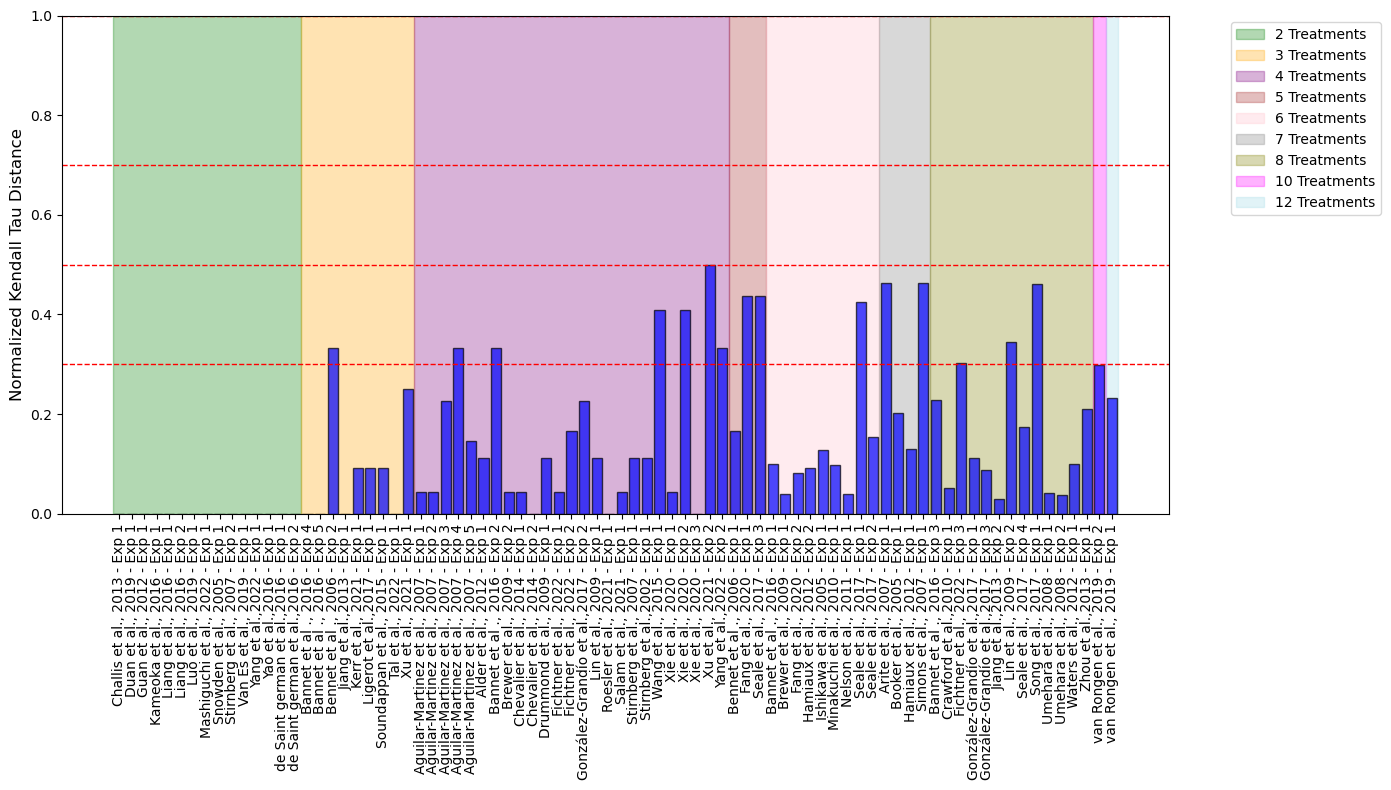

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_normalized_kendall(data_file, output_image):
    # Load the processed data
    data = pd.read_csv(data_file)

    # Ensure relevant columns are strings
    data['Experiment'] = data['Experiment'].astype(str)
    data['Paper'] = data['Paper'].astype(str)
    data['Publication'] = data['Publication'].astype(str)

    # Count the number of treatments per experiment (as an integer)
    data['Experiment_Treatments'] = (
        data.groupby(['Paper', 'Experiment'])['Psoup Treatment']
            .transform('count')
            .astype(int)
    )

    # Create a unique identifier for each experiment (combining publication and experiment)
    data['Experiment_ID'] = data['Publication'] + ' - Exp ' + data['Experiment']

    # Create a DataFrame with unique experiment information
    experiments_info = data[['Experiment_ID', 'Experiment_Treatments']].drop_duplicates()

    # Sort experiments by treatment count (and then by Experiment_ID) for verification and plotting
    experiments_info_sorted = experiments_info.sort_values(by=['Experiment_Treatments', 'Experiment_ID'])
    
    # --- Print the experiment info for verification ---
    print("Number of treatments for each experiment (sorted):")
    print(experiments_info_sorted.to_string(index=False))
    # ---------------------------------------------------

    # Aggregate normalized Kendall Tau distances (average per experiment)
    plot_data = data.groupby('Experiment_ID')['Normalized Kendall Distance'].mean().reset_index()

    # Merge in the treatment count information
    plot_data = pd.merge(plot_data, experiments_info, on='Experiment_ID')

    # Reorder plot_data so that its rows appear in the same order as experiments_info_sorted
    plot_data = plot_data.set_index('Experiment_ID').loc[experiments_info_sorted['Experiment_ID']].reset_index()

    # Create x-axis labels (experiment IDs) in the sorted order
    x_labels = plot_data['Experiment_ID'].tolist()

    # Determine unique treatment counts (include all, even if only one experiment is in a group)
    treatment_counts = sorted(plot_data['Experiment_Treatments'].unique())

    # Define a fixed color mapping so that, for example, experiments with 2 treatments are green.
    fixed_color_mapping = {
        1: "#1f77b4",   # Blue
        2: "green",     # Green
        3: "orange",    # Orange
        4: "purple",    # Purple
        5: "brown",
        6: "pink",
        7: "gray",
        8: "olive",
        9: "cyan",
        10: "magenta"
    }
    
    # For treatment counts not defined in our fixed mapping, fall back to a colormap.
    cmap = get_cmap('tab20')
    def get_color(t):
        if t in fixed_color_mapping:
            return fixed_color_mapping[t]
        else:
            # Use a fallback: map t to a color using the colormap
            idx = treatment_counts.index(t)
            return cmap(idx / max(1, len(treatment_counts) - 1))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # For each treatment group, add a background color spanning the corresponding bars
    for t in treatment_counts:
        indices = plot_data.index[plot_data['Experiment_Treatments'] == t]
        if len(indices) > 0:
            ax.axvspan(
                indices.min() - 0.5, 
                indices.max() + 0.5,
                color=get_color(t), 
                alpha=0.3, 
                label=f'{t} Treatments'
            )

    # Plot the bars for the normalized Kendall Tau distances
    ax.bar(
        x_labels,
        plot_data['Normalized Kendall Distance'],
        color='blue',  # Bar color remains blue (you can change this if desired)
        edgecolor='black',
        alpha=0.7
    )

    # Add horizontal red dashed lines at specified y-values
    for y_value in [0.3, 0.5, 0.7, 1]:
        ax.axhline(y=y_value, color='red', linestyle='--', linewidth=1)

    # Configure the x-axis: use the sorted experiment IDs as tick labels
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

    # Configure the y-axis
    ax.set_ylabel('Normalized Kendall Tau Distance', fontsize=12)
    ax.set_ylim(0, 1)

    # Add a legend (positioned outside the plot area)
    ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1.05, 1))

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(output_image)
    plt.show()

# Example usage:
plot_normalized_kendall(
    data_file=r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Desktop\Paper\Dataset\Training\Benchmark_Model\Kendall_Tau_Results_1.csv',
    output_image=r'C:\Users\uqcmitsa\OneDrive - The University of Queensland\Desktop\Paper\Dataset\Training\Benchmark_Model\Kendall_Tau_Bar_Plot_new.png'
)
